In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os
import copy
import math

In [ ]:
SEED        = 123
N_SPLITS    = 5
EPOCHS      = 20
BATCH_SIZE  = 64
LR          = 1e-3
WEIGHT_DECAY= 1e-4
IMAGE_SHAPE = (28, 28)
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=SEED):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

set_seed()

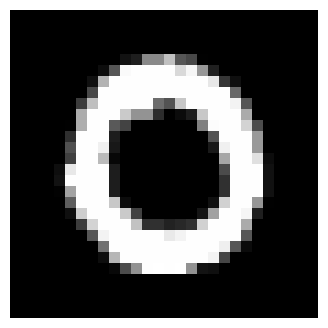

In [ ]:
df_train = pd.read_csv("/content/train.csv")
d_test = pd.read_csv("/content/test.csv")

images_np = df_train.drop("label", axis=1).values
labels_np = df_train["label"].values

plt.figure(figsize=(4,4))
plt.imshow(images_np[1].reshape(28,28), cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.expand(3, x.shape[1], x.shape[2])),   # [1,H,W] -> [3,H,W]
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.expand(3, x.shape[1], x.shape[2])),   # [1,H,W] -> [3,H,W]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, images, labels, image_shape=(28,28), scale=True, add_channel=True, transform=None):
        self.images = torch.as_tensor(images, dtype=torch.float32)   # [N, 784]
        self.labels = torch.as_tensor(labels, dtype=torch.long)
        self.image_shape = image_shape
        self.scale = scale
        self.add_channel = add_channel
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.images[idx]            
        y = self.labels[idx]

        # skala jika masih 0.255 (hindari double scale)
        if self.scale and x.max() > 1:
            x = x / 255.0
        # reshape flat -> [H,W]
        if x.ndim == 1:
            x = x.view(*self.image_shape)

        # tambah channel -> [1,H,W]
        if self.add_channel and x.ndim == 2:
            x = x.unsqueeze(0)

        # apply transform (bekerja pada Tensor [C,H,W])
        if self.transform is not None:
            x = self.transform(x)

        return x, y

In [ ]:
class VGG16_net(nn.Module):
    def __init__(self, in_channels=3, n_classes=10, dropout: float = 0.5, freeze_backbone=False):
        super().__init__()

        # Load pretrained VGG16
        weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
        net = models.vgg16(weights=weights)

        # Nếu muốn đóng băng backbone
        if freeze_backbone:
            for param in net.features.parameters():
                param.requires_grad = False

        # Thay lớp cuối bằng Identity để lấy đặc trưng
        feat_dim = net.classifier[-1].in_features
        net.classifier[-1] = nn.Identity()
        self.backbone = net

        # Phân loại mới
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, 4096),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [ ]:
def _warmup_cosine(optimizer, epochs, warmup=3, base_lr=5e-4, min_lr=1e-6):
    import math
    minf = max(min_lr / max(base_lr, 1e-12), 1e-4)
    def lr_lambda(epoch):
        if epoch < warmup:
            return (epoch + 1) / max(1, warmup)
        t = (epoch - warmup) / max(1, epochs - warmup)
        return minf + (1 - minf) * 0.5 * (1 + math.cos(math.pi * t))
    return LambdaLR(optimizer, lr_lambda=lr_lambda)


# Plot traininaning_curves(history, show=True, save_dir=None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    epochs = history["epoch"]

    return LambdaLR(optimizer, lr_lambda=lr_lambda)

# Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history["train_loss"], label="train_loss")
    if len(history["val_loss"]) > 0:
        plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training/Validation Loss")
    plt.legend()
    plt.grid(True)

    if save_dir:
        plt.savefig(os.path.join(save_dir, "loss.png"), bbox_inches="tight")
    if show:
        plt.show()
    plt.close()

    # Accuracy
    if len(history["train_acc"]) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, history["train_acc"], label="train_acc")
        if len(history["val_acc"]) > 0:
            plt.plot(epochs, history["val_acc"], label="val_acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title("Training/Validation Accuracy")
        plt.legend()
        plt.grid(True)

        if save_dir:
            plt.savefig(os.path.join(save_dir, "acc.png"), bbox_inches="tight")
        if show:
            plt.show()
        plt.close()


In [ ]:
# Checkpoint
def save_checkpoint(model, optimizer, epoch, history, filepath="checkpoints/last.pth"):
    """Lưu checkpoint của model."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "history": history
    }
    torch.save(checkpoint, filepath)
    print(f" Saved checkpoint at epoch {epoch+1} to {filepath}")

In [ ]:
#Load model
def load_checkpoint(model, optimizer, filepath="checkpoints/last.pth", device="cpu"):
    """Tải checkpoint của model."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Checkpoint file {filepath} not found")

    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint.get("epoch", 0)
    history = checkpoint.get("history", {
        "epoch": [], "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [], "lr": []
    })

    if "epoch" not in checkpoint or "history" not in checkpoint:
        print("Warning: Checkpoint missing 'epoch' or 'history' — resuming from 0")

    print(f" Resumed from epoch {epoch+1}")
    return model, optimizer, epoch, history


In [ ]:
#Train loop
def train_model(model, train_loader, val_loader=None,
                num_epochs=20, lr=5e-4, weight_decay=1e-4,
                label_smoothing=0.05,
                warmup_epochs=3, min_lr=1e-6,
                patience=10, min_delta=1e-5, max_grad_norm=1.0,
                plot=True, save_plots_dir=None, return_history=False,
                checkpoint_dir="checkpoints", resume=False, checkpoint_path="checkpoints/last.pth",
                csv_path="checkpoints/history.csv"):

    model = model.to(DEVICE)
    crit = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    sch = _warmup_cosine(opt, num_epochs, warmup_epochs, lr, min_lr)

    history = {"epoch": [], "train_loss": [], "val_loss": [],
               "train_acc": [], "val_acc": [], "lr": []}

    start_epoch = 0
    if resume and os.path.exists(checkpoint_path):
        model, opt, start_epoch, history = load_checkpoint(model, opt, checkpoint_path, DEVICE)
        for _ in range(start_epoch):
            sch.step()

    best_loss, best_epoch, bad_epochs, best_state = float('inf'), -1, 0, None

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss, running_correct, total_samples = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for x, y in train_loop:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)

            if x.ndim == 5:
                B, S, C, H, W = x.shape
                x = x.view(B * S, C, H, W)
                y = y.repeat_interleave(S)

            logits = model(x)
            loss = crit(logits, y)
            loss.backward()

            if max_grad_norm > 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            opt.step()

            batch_size = y.size(0)
            running_loss += loss.item() * batch_size
            running_correct += (logits.argmax(1) == y).sum().item()
            total_samples += batch_size

            train_loop.set_postfix({
                'loss': f"{running_loss/total_samples:.4f}",
                'acc': f"{100.0*running_correct/total_samples:.2f}%"
            })

        train_loss = running_loss / total_samples
        train_acc = 100.0 * running_correct / total_samples
        cur_lr = opt.param_groups[0]["lr"]
        sch.step()

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | LR: {cur_lr:.6f}")

        val_loss, val_acc = None, None
        if val_loader is not None:
            model.eval()
            val_running_loss, val_running_correct, val_total_samples = 0.0, 0, 0

            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    logits = model(x)
                    val_running_loss += crit(logits, y).item() * y.size(0)
                    val_running_correct += (logits.argmax(1) == y).sum().item()
                    val_total_samples += y.size(0)

            val_loss = val_running_loss / val_total_samples
            val_acc = 100.0 * val_running_correct / val_total_samples
            print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%\n")

            save_checkpoint(model, opt, epoch, history, filepath=checkpoint_path)

            if val_loss < best_loss - min_delta:
                best_loss, best_epoch, bad_epochs = val_loss, epoch + 1, 0
                best_state = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
            else:
                bad_epochs += 1
                if bad_epochs >= patience:
                    print(f"Early stopping at epoch {epoch+1}. Best val loss {best_loss:.4f}")
                    break

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(cur_lr)

        pd.DataFrame(history).to_csv(csv_path, index=False)

    if best_state:
        print(f"Best model at epoch {best_epoch} (val loss {best_loss:.4f})")
        model.load_state_dict(best_state)
    else:
        print("Training completed without validation")

    if plot:
        _plot_training_curves(history, show=False, save_dir=save_plots_dir)

    return (model, history) if return_history else model

In [ ]:
#Main
from sklearn.model_selection import train_test_split

def main():
    set_seed()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, "last.pth")
    csv_path = os.path.join(checkpoint_dir, "history.csv")

    df_train = pd.read_csv("/content/train.csv")
    df_test  = pd.read_csv("/content/test.csv")

    images_np = df_train.drop("label", axis=1).values
    labels_np = df_train["label"].values


    X_train, X_val, y_train, y_val = train_test_split(
        images_np, labels_np, test_size=0.1, random_state=SEED, stratify=labels_np
    )

    train_dataset = DigitDataset(X_train, y_train, image_shape=IMAGE_SHAPE, transform=train_tf)
    val_dataset   = DigitDataset(X_val, y_val, image_shape=IMAGE_SHAPE, transform=val_tf)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = VGG16_net(in_channels=3, n_classes=10).to(device)

    model, history = train_model(
        model,
        train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        checkpoint_dir=checkpoint_dir,
        resume=False,          # True nếu muốn load từ checkpoint
        plot=True,
        return_history=True,
        csv_path=csv_path
    )

    # 7️Lưu model cuối cùng
    os.makedirs("saved_models", exist_ok=True)
    model_save_path = "saved_models/vgg16_mnist.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"✅ Model saved to {model_save_path}")

    # 8️⃣ In final loss/accuracy
    print("Training completed!")
    print("Final train loss:", history["train_loss"][-1])
    print("Final train acc:", history["train_acc"][-1])
    if history["val_loss"][-1] is not None:
        print("Final val loss:", history["val_loss"][-1])
        print("Final val acc:", history["val_acc"][-1])

if __name__ == "__main__":
    main()

Using device: cuda


Epoch 1/20:   0%|          | 0/591 [00:00<?, ?it/s]

Train Loss: 0.5222 | Acc: 92.19% | LR: 0.000333
Val Loss: 0.3368 | Acc: 98.76%

✅ Saved checkpoint at epoch 1 to checkpoints/last.pth


Epoch 2/20:   0%|          | 0/591 [00:00<?, ?it/s]

Train Loss: 0.3939 | Acc: 97.39% | LR: 0.000667
Val Loss: 0.3595 | Acc: 98.40%

✅ Saved checkpoint at epoch 2 to checkpoints/last.pth


Epoch 3/20:   0%|          | 0/591 [00:00<?, ?it/s]

Train Loss: 0.4188 | Acc: 96.72% | LR: 0.001000
Val Loss: 0.3524 | Acc: 98.17%

✅ Saved checkpoint at epoch 3 to checkpoints/last.pth


Epoch 4/20:   0%|          | 0/591 [00:00<?, ?it/s]

Train Loss: 0.3908 | Acc: 97.37% | LR: 0.001000
Val Loss: 0.3533 | Acc: 98.50%

✅ Saved checkpoint at epoch 4 to checkpoints/last.pth


Epoch 5/20:   0%|          | 0/591 [00:00<?, ?it/s]

Train Loss: 0.3721 | Acc: 97.86% | LR: 0.000991
Val Loss: 0.3389 | Acc: 98.50%

✅ Saved checkpoint at epoch 5 to checkpoints/last.pth


Epoch 6/20:   0%|          | 0/591 [00:00<?, ?it/s]

Train Loss: 0.3604 | Acc: 98.14% | LR: 0.000966
Val Loss: 0.3318 | Acc: 98.88%



KeyboardInterrupt: 